# Hands-on 02: Caracterização do desvanecimento de pequena escala


## Parte 01: Separação dos desvanecimentos de Larga e Pequena escalas


### Objetivos
As metas desse tutorial são ajudar o usuário a:
- Gerar uma série temporal sintética com Perda de Percurso, Sombreamento e Desvanecimento m-Nakagami;
- Estimar cada desvanecimento por meio de regressão linear, filtragem e tratamento estatístico;
- Fazer gráficos e comparar as partes geradas sinteticamente e as partes estimadas.


## Prática 01: Criação do sinal sintético

Vamos escrever um código para criação de um sinal sintético com Perda de Percurso (modelo decaimento logaritmo), Sombreamento Log-Normal e Desvanecimento m-Nakagami. O código deve ser parametrizável e as séries temporais devem ser salvas em arquivo. Gráficos devem ilustrar o comportamento de cada parte do sinal sintético.


**Passo 01:** Crie um script chamado **handson3_P1_1.py** com o código a seguir. Nesse código, vamos:

1. Criar a estrutura **sPar** de entrada de parâmetros;
2. Gerar um canal com desvanecimento de larga e pequena escalas;
3. A perda de percurso segue o modelo de log-linear com coeficiente de perda de percurso especificado por **sPar['n']**.  geração da perda de percurso deve seguir as seguintes especificações:
 - O modelo da perda de percurso é $PL = P_0 + 10\cdot n\cdot log10(d/d_0)$, sendo $P_0$ a potência medida na distância de referência $d_0$, especificadas por **sPar['P0']** e **sPar['d0']**, respectivamente; 
 - A distância final da rota de medição é especificada por **sPar['totalLength']** em metros;
 - O número de pontos de medição é especificado por **sPar['nPoints']**;
4. O sombreamento $Xs$ segue um modelo log-normal com média zero e desvio padrão especificado por **sPar['sigma']**. A geração do sombreamento deve seguir as seguintes especificações:
 - Amostras de sombreamento independentes devem sorteadas para pontos de medição em uma janela de **sPar['shadowingWindow']**  amostras (isso quer dizer que depois de **sPar['shadowingWindow']**  amostras, o sombreamento é descorrelacionado);
 - Amostras dentro de uma janela especificada por **sPar['shadowingWindow']** devem ser iguais com intuito de modelar o sombreamento correlacionado; 
 - Para evitar variações brutas entre amostras independentes do sombreamento, um filtro média móvel com janela igual a **sPar['shadowingWindow']** deve ser aplicado ao vetor de amostras de sombreamento;
 - Ajustes na média e no desvio padrão devem ser feitos para garantir seus valores amostrais;
5. O desvanecimento de pequena escala $Xf$ segue um modelo m-Nakagami com o valor de $m$ especificado por **sPar['m']**. A geração do desvanecimento de pequena escala deve seguir as seguintes especificações:
 - A PDF da envoltória do sinal é m-Nakagami normalizada igual a $f(x; m) = \frac{2\cdot m^m}{\Gamma(m)}\cdot x^{2\cdot m-1} \cdot e^{-m\cdot x^2} $ [[fonte]](https://pdfs.semanticscholar.org/3e81/7c531d90f63a3c43fe7076189e942d6fed01.pdf);
5. Calcular a potência recebida como: $Prx = Ptx - PL + Xs + Xf$, todos em dB.

Canal sintético:
   Média do sombreamento: -0.0264
   Std do sombreamento: 5.6669
   Janela de correlação do sombreamento: 200 amostras
   Expoente de path loss: 4
   m de Nakagami: 4


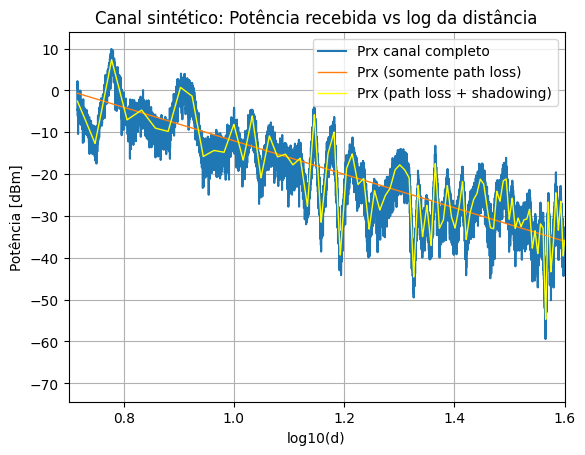

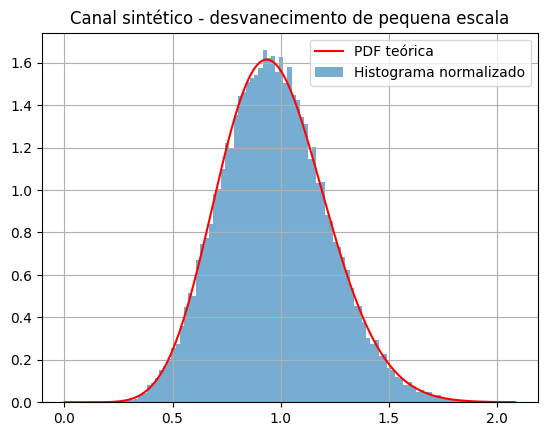

In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
from scipy.stats import nakagami
from scipy.special import gamma

# ---------- Parâmetros para geração do canal sintético ----------
sPar = {
    'd0': 5,                         # distância de referência d0
    'P0': 0,                         # Potência na distância de referência (dBm)
    'nPoints': 50000,               # Número de amostras
    'totalLength': 100,             # Distância total da rota
    'n': 4,                          # Expoente de perda de percurso
    'sigma': 6,                     # Desvio padrão do shadowing (dB)
    'shadowingWindow': 200,         # Tamanho da janela de correlação
    'm': 4,                          # Parâmetro de Nakagami
    'txPower': 0,                   # Potência de transmissão (dBm)
    'nCDF': 40,
    'chFileName': 'Prx_sintetico'
}

sPar['dMed'] = sPar['totalLength'] / sPar['nPoints']

# ---------- Geração do vetor de distâncias ----------
vtDist = np.arange(sPar['d0'], sPar['totalLength'], sPar['dMed'])
nSamples = len(vtDist)

# ---------- Perda de percurso determinística ----------
vtPathLoss = sPar['P0'] + 10*sPar['n']*np.log10(vtDist / sPar['d0'])

# ---------- Geração do sombreamento ----------
nShadowSamples = mt.floor(nSamples / sPar['shadowingWindow'])
vtShadowing = sPar['sigma'] * np.random.randn(nShadowSamples)

# Amostras para a última janela
restShadowing = sPar['sigma'] * np.random.randn(1) * np.ones(nSamples % sPar['shadowingWindow'])

# Repetição do mesmo valor durante a janela de correlação

vtShadowing = np.tile(vtShadowing, (sPar['shadowingWindow'], 1))
vtShadowing = vtShadowing.T.flatten()
vtShadowingVec = np.concatenate((vtShadowing, restShadowing))

# ---------- Filtragem do sombreamento (média móvel) ----------
jan = sPar['shadowingWindow'] // 2
vtShadCorr = []

for i in range(jan, nSamples - jan):
    vtShadCorr.append(np.mean(vtShadowing[i - jan:i + jan + 1]))
vtShadCorr = np.array(vtShadCorr)

# ---------- Ajuste de desvio padrão após filtragem ----------
vtShadCorr = vtShadCorr * np.std(vtShadowingVec) / np.std(vtShadCorr)
vtShadCorr = vtShadCorr - np.mean(vtShadCorr) + np.mean(vtShadowingVec)

# ---------- Geração do desvanecimento de pequena escala (Nakagami) ----------
# PDF de Nakagami para amostragem
m = sPar['m']
fpNakaPdf = lambda x: ((2* (m**m))/gamma(m))*x**(2*m-1)*np.exp(-m*x**2)

# Amostras com distribuição de Nakagami (envelope normalizado)
# Usando scipy.stats.nakagami para gerar diretamente
vtNakagamiNormEnvelope = nakagami.rvs(m, size=nSamples)

# Fading em dB
vtNakagamiSampdB = 20 * np.log10(vtNakagamiNormEnvelope)

# ---------- Cálculo da potência recebida ----------
# Ajuste nos vetores devido à filtragem do shadowing
vtTxPower = sPar['txPower'] * np.ones(nSamples)
vtTxPower = vtTxPower[jan:nSamples - jan]
vtPathLoss = vtPathLoss[jan:nSamples - jan]
vtFading = vtNakagamiSampdB[jan:nSamples - jan]
vtDist = vtDist[jan:nSamples - jan]

vtPrx = vtTxPower - vtPathLoss + vtShadCorr + vtFading

# ---------- Salvamento dos dados em arquivo .npz ----------
np.savez(f"{sPar['chFileName']}.npz",
         vtDist=vtDist,
         vtPathLoss=vtPathLoss,
         vtShadCorr=vtShadCorr,
         vtFading=vtFading,
         vtPrx=vtPrx)

# ---------- Exibição de informações ----------
print('Canal sintético:')
print(f'   Média do sombreamento: {np.mean(vtShadCorr):.4f}')
print(f'   Std do sombreamento: {np.std(vtShadCorr):.4f}')
print(f'   Janela de correlação do sombreamento: {sPar["shadowingWindow"]} amostras')
print(f'   Expoente de path loss: {sPar["n"]}')
print(f'   m de Nakagami: {sPar["m"]}')

# ---------- Gráfico da potência recebida ----------
plt.figure()
log_distancia = np.log10(vtDist)
plt.plot(log_distancia, vtPrx, label='Prx canal completo')
plt.plot(log_distancia, sPar['txPower'] - vtPathLoss, label='Prx (somente path loss)', linewidth=1)
plt.plot(log_distancia, sPar['txPower'] - vtPathLoss + vtShadCorr, label='Prx (path loss + shadowing)', linewidth=1, color='yellow')
plt.xlabel('log10(d)')
plt.ylabel('Potência [dBm]')
plt.title('Canal sintético: Potência recebida vs log da distância')
plt.legend()
plt.xlim([0.7, 1.6])
plt.grid(True)

# ---------- Gráfico do desvanecimento Nakagami ----------
plt.figure()
f_hist, x_hist = np.histogram(vtNakagamiNormEnvelope, bins=100, density=True)
x_centers = (x_hist[:-1] + x_hist[1:]) / 2
plt.bar(x_centers, f_hist, width=(x_hist[1] - x_hist[0]), alpha=0.6, label='Histograma normalizado')
x_pdf = np.linspace(0, np.max(vtNakagamiNormEnvelope), 1000)
plt.plot(x_pdf, fpNakaPdf(x_pdf), 'r', label='PDF teórica')
plt.title('Canal sintético - desvanecimento de pequena escala')
plt.legend()
plt.grid(True)

plt.show()

**A execução do código resulta em:**
1. Mensagem de texto com informações sobre o canal sintético gerado;
2. Os seguinte vetores:
 - vtDist: Pontos de medição [m];
 - vtPathLoss: Amostras da perda de percurso; 
 - vtShadCorr: Amostras do sombreamento;
 - vtFading: Amostras do desvanecimento de pequena escala;
 - vtPrx: Potência recebida com o canal completo.
3. Um arquivo .npz com nome especificado no parâmetro **sPar['fileName']**;
4. Um gráfico mostrando a potência recebida com desvanecimento de larga e pequena escalas;
5. Gráfico com histograma e PDF m-Nakagami do desvanecimento de pequena escala.
 
**Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas.**

## Prática 02: Estimação do parâmetros do canal

Vamos escrever um código para, de posse do sinal medido, estimarmos a Perda de Percurso (modelo decaimento logaritmo), o Sombreamento Log-Normal (seu desvio padrão) e Desvanecimento de pequena escala (sua distribuição e parâmetros). O código deve ser parametrizável e gráficos devem ilustrar o comportamento de cada parte do sinal original e estimado.

**Passo 01:** Crie uma função chamada **fGeraCanal.py** com o código a seguir. Ele é uma versão do código **handson3_P1_1.py** escrito em forma de função. Isso foi feito para melhor organizar o código da prática 02.

In [2]:
import numpy as np
import math as mt
from scipy.special import gamma
from scipy.stats import nakagami
import matplotlib.pyplot as plt

def gera_canal(sPar):
    nPoints = sPar['nPoints']
    totalLength = sPar['totalLength']
    P0 = sPar['P0']
    d0 = sPar['d0']
    n = sPar['n']
    sigma = sPar['sigma']
    shadowingWindow = sPar['shadowingWindow']
    m = sPar['m']
    dMed = sPar['dMed']
    txPower = sPar['txPower']

    # Distância do transmissor
    d = np.arange(d0, totalLength, dMed)
    nSamples = len(d)

    # Perda de percurso
    vtPathLoss = P0 + 10*n*np.log10(d/d0)

    # Sombreamento
    nShadowSamples = mt.floor(nSamples / shadowingWindow)
    shadowing = sigma * np.random.randn(nShadowSamples)
    restShadowing = sigma * np.random.randn(1) * np.ones(nSamples % shadowingWindow)
    shadowing = np.tile(shadowing, (shadowingWindow, 1))
    shadowing = shadowing.T.flatten()
    shadowing = np.concatenate((shadowing, restShadowing))

    # Filtro de média móvel
    jan = shadowingWindow // 2
    vtShadCorr = []
    for i in range(jan, nSamples - jan):
        vtShadCorr.append(np.mean(shadowing[i - jan:i + jan + 1]))
    vtShadCorr = np.array(vtShadCorr)

    # Ajuste do desvio padrão
    vtShadCorr *= np.std(shadowing) / np.std(vtShadCorr)
    vtShadCorr += np.mean(shadowing) - np.mean(vtShadCorr)

    # Nakagami PDF
    #def nakagami_pdf(x):
     #   return (2 * (m ** m) / gamma(m)) * (x ** (2 * m - 1)) * np.exp(-m * x ** 2)

    # Amostragem via rejeição
    #x_vals = np.linspace(0, 3, 5000)
   # pdf_vals = nakagami_pdf(x_vals)
   # max_pdf = np.max(pdf_vals)
    #nakagami_samples = []
    #while len(nakagami_samples) < nSamples:
     #   x_try = np.random.uniform(0, 3)
      #  y_try = np.random.uniform(0, max_pdf)
       # if y_try < nakagami_pdf(x_try):
        #    nakagami_samples.append(x_try)
    #nakagami_samples = np.array(nakagami_samples[:nSamples])
    #nakagamiSamp = 20 * np.log10(nakagami_samples)
    fpNakaPdf = lambda x: ((2* (m**m))/gamma(m))*x**(2*m-1)*np.exp(-m*x**2)
    # Amostras com distribuição de Nakagami (envelope normalizado)
    # Usando scipy.stats.nakagami para gerar diretamente
    vtNakagamiNormEnvelope = nakagami.rvs(m, size=nSamples)
    # Fading em dB
    vtNakagamiSampdB = 20 * np.log10(vtNakagamiNormEnvelope)

    # Ajuste de tamanho por causa da filtragem
    txPowerVec = txPower * np.ones(nSamples)
    txPowerVec = txPowerVec[jan:nSamples - jan]
    vtPathLoss = vtPathLoss[jan:nSamples - jan]
    vtFading = vtNakagamiSampdB[jan:nSamples - jan]
    vtDist = d[jan:nSamples - jan]

    # Potência recebida
    vtPrxdBm = txPowerVec - vtPathLoss + vtShadCorr + vtFading
    # ---------- Salvamento dos dados em arquivo .npz ----------
    np.savez(f"{sPar['chFileName']}.npz",
         vtDist=vtDist,
         vtPathLoss=vtPathLoss,
         vtShadCorr=vtShadCorr,
         vtFading=vtFading,
         vtPrxdBm=vtPrxdBm)
    
    return vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm


**Passo 02:** Crie um script chamado **handson3_P2_1.py** com o código a seguir. Nesse código, vamos:

1. Separar o desvanecimento de larga e pequena escalas. Para isso, faça:
 - De posse da série temporal que representa a potência recebida **vtPrx**, passe um filtro média móvel com janela especificada no parâmetro **sPar['dW']**;
 - A saída do filtro será o desvanecimento de larga escala estimado **vtDesLarga**. Ele é a perda de percurso somanda com o sombreamento;
 - Para cálcular a série temporal que representa o desvanecimento de pequena escala, é só subtrair o desvanecimento de larga escala estimado da potência recebida **vtPrx** - **vtDesLarga**; 
2. Usar interpolação linear em **vtPrx** para estimar a perda de percurso **vtPathLossEst**;
3. Informar o expooente de perda de percurso estimado;
4. Fazer um gráfico da perda de percurso original e estimada (comparação visual);
5. De posse da perda de percurso e do desvanecimento de larga escala, calcular a série temporal que representa o sombreamento: **vtDesLarga** - **vtPathLossEst**;
6. Fazer gráficos comparando cada série estimada com seu par original;
7. Estimar a CDF normalizada do desvanecimento de pequena escala e comparar com a formulação teórica do m-Nakagami para alguns valores de $m$.

   Estimação dos parâmetros de larga escala (W = 100):
   Expoente de perda de percurso estimado n = 3.8667
   Desvio padrão do sombreamento estimado = 5.9167
   Média do sombreamento estimado = 0.7969


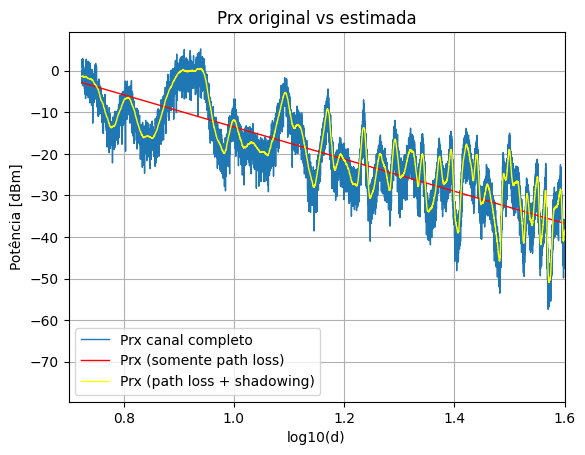

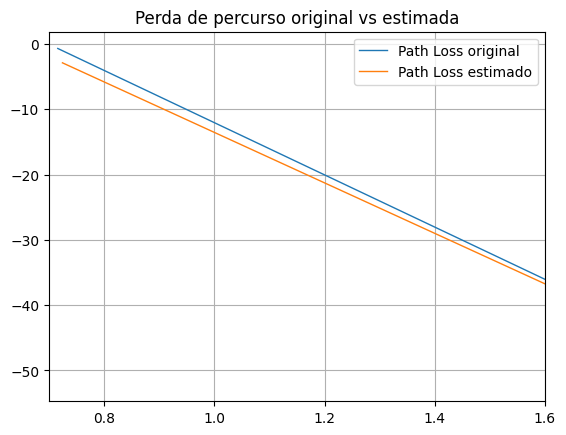

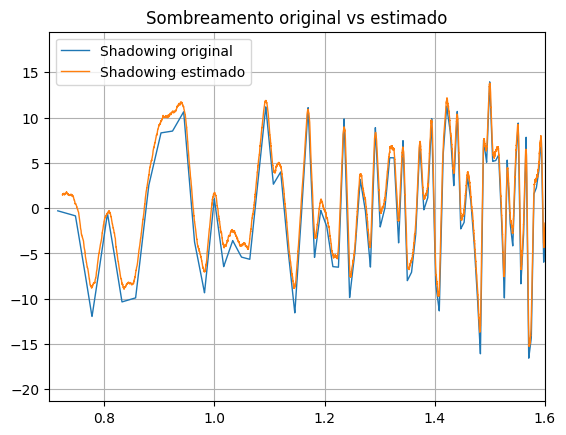

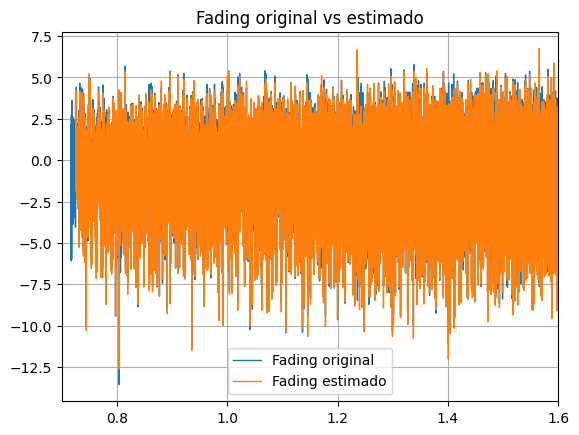

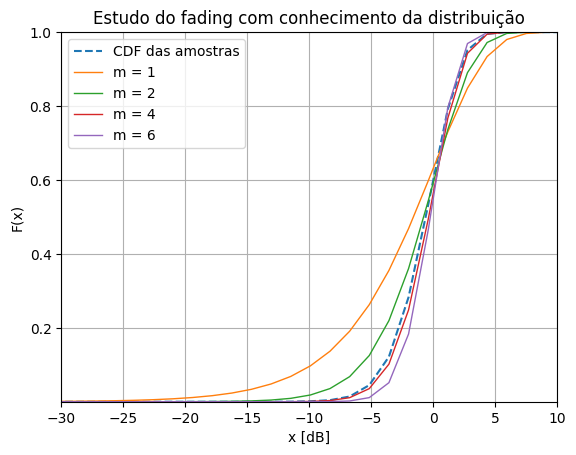

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammainc
from scipy.stats import nakagami, kstest
from fGeraCanal import gera_canal

# Parâmetros para geração do canal sintético
sPar = {
    'd0': 5,
    'P0': 0,
    'nPoints': 50000,
    'totalLength': 100,
    'n': 4,
    'sigma': 6,
    'shadowingWindow': 200,
    'm': 4,
    'txPower': 0,
    'nCDF': 40,
    'dW': 100,
    'chFileName': 'Prx_sintetico'
}
sPar['dMed'] = sPar['totalLength'] / sPar['nPoints']

# Gera o canal sintético
vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm = gera_canal(sPar)

# Transforma potência de dBm para mW
vtPtrxmW = 10 ** (vtPrxdBm / 10)
nSamples = len(vtPtrxmW)

# Cálculo do desvanecimento lento e rápido
dMeiaJanela = round((sPar['dW'] - 1) / 2)
vtDesLarga = []
vtDesPequeEst = []

for ik in range(dMeiaJanela +1, nSamples - dMeiaJanela):
    media_janela = np.mean(vtPtrxmW[ik - dMeiaJanela:ik + dMeiaJanela])
    des_larga = 10 * np.log10(media_janela)
    vtDesLarga.append(des_larga)
    des_peq = vtPrxdBm[ik] - des_larga
    vtDesPequeEst.append(des_peq)

# Envoltória normalizada
indexes = range(dMeiaJanela+1, nSamples - dMeiaJanela)
vtPtrxmWNew = 10 ** (vtPrxdBm[indexes] / 10)
desLarga_Lin = 10 ** (np.array(vtDesLarga) / 10)
envNormal = np.sqrt(vtPtrxmWNew) / np.sqrt(desLarga_Lin)

# Ajuste nos vetores
vtDistEst = vtDist[dMeiaJanela+1:nSamples - dMeiaJanela]
vtPrxdBm = vtPrxdBm[dMeiaJanela+1:nSamples - dMeiaJanela]

# Estimativa da perda de percurso
vtDistLog = np.log10(vtDist)
vtDistLogEst = np.log10(vtDistEst)
dCoefReta = np.polyfit(vtDistLogEst, vtPrxdBm, 1)
dNEst = -dCoefReta[0] / 10
print(f'   Estimação dos parâmetros de larga escala (W = {sPar["dW"]}):')
print(f'   Expoente de perda de percurso estimado n = {dNEst:.4f}')

vtPathLossEst = np.polyval(dCoefReta, vtDistLogEst)
vtShadCorrEst = np.array(vtDesLarga) - vtPathLossEst
stdShad = np.std(vtShadCorrEst)
meanShad = np.mean(vtShadCorrEst)
print(f'   Desvio padrão do sombreamento estimado = {stdShad:.4f}')
print(f'   Média do sombreamento estimado = {meanShad:.4f}')

vtPathLossEst = -vtPathLossEst
vtPrxEst = sPar['txPower'] - vtPathLossEst + vtShadCorrEst + np.array(vtDesPequeEst)

# Estimativa da CDF do fading
vtn = np.arange(1, sPar['nCDF'])
xCDF = 1.2 ** (vtn - 1) * 0.01
cdffn = np.array([np.sum(envNormal <= x) for x in xCDF])
yccdfEst = cdffn / cdffn[-1]
xccdfEst = 20 * np.log10(xCDF)

# Gráficos
plt.figure()
plt.plot(vtDistLogEst, vtPrxEst, label='Prx canal completo', linewidth=1)
plt.plot(vtDistLogEst, sPar['txPower'] - vtPathLossEst, label='Prx (somente path loss)', color='red', linewidth=1)
plt.plot(vtDistLogEst, sPar['txPower'] - vtPathLossEst + vtShadCorrEst, label='Prx (path loss + shadowing)', color='yellow', linewidth=1)
plt.xlabel('log10(d)')
plt.ylabel('Potência [dBm]')
plt.title('Prx original vs estimada')
plt.xlim([0.7, 1.6])
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(vtDistLog, -vtPathLoss, label='Path Loss original', linewidth=1)
plt.plot(vtDistLogEst, -vtPathLossEst, label='Path Loss estimado', linewidth=1)
plt.title('Perda de percurso original vs estimada')
plt.xlim([0.7, 1.6])
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(vtDistLog, vtShadCorr, label='Shadowing original', linewidth=1)
plt.plot(vtDistLogEst, vtShadCorrEst, label='Shadowing estimado', linewidth=1)
plt.title('Sombreamento original vs estimado')
plt.xlim([0.7, 1.6])
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(vtDistLog, vtFading, label='Fading original', linewidth=1)
plt.plot(vtDistLogEst, vtDesPequeEst, label='Fading estimado', linewidth=1)
plt.title('Fading original vs estimado')
plt.xlim([0.7, 1.6])
plt.legend()
plt.grid(True)

# CDFs comparativas com Nakagami
plt.figure()
plt.plot(xccdfEst, yccdfEst, '--', label='CDF das amostras')
vtm = [1, 2, 4, 6]
xCDF_lin = 10 ** (xccdfEst / 20)
for m in vtm:
    #cdfnaka = gammainc(m * xCDF_lin ** 2, m)
    cdfnaka = gammainc(m, m*xCDF_lin**2)
    plt.plot(20 * np.log10(xCDF_lin), cdfnaka, label=f'm = {m}', linewidth=1)
plt.axis([-30, 10, 1e-5, 1])
plt.xlabel('x [dB]')
plt.ylabel('F(x)')
plt.title('Estudo do fading com conhecimento da distribuição')
plt.legend()
plt.grid(True)

plt.show()

## Prática 03: Influência da janela de filtragem para separação dos desvanecimentos de larga e pequena escalas e estimação da distribuição do fading

Vamos escrever um código para estimar o desvanecimento de pequena escala (sua distribuição e parâmetros) e investigar a influência do tamanho da janela de filtragem para separação dos desvanecimentos de larga e pequena escalas. O código irá aplicar alguns testes estatísticos e fará um estudo com o conhecimento a priori do canal e sem seu conhecimento.

**Passo 01:** Crie uma função chamada **fGeraCanal.py** da prática 02.


**Passo 02:** Crie uma função chamada **fEstimaCanal.py** com o código a seguir. Ele é uma versão do código **handson3_P2_1.py** escrito em forma de função. Isso foi feito para melhor organizar o código da prática 03.



In [4]:
import numpy as np

def f_estima_canal(sPar):
    # Carrega os dados salvos no arquivo .npz
    data = np.load(sPar['chFileName']+".npz")
    vtPrxdBm = data['vtPrxdBm']
    vtDist = data['vtDist']

    vtPtrxmW = 10 ** (vtPrxdBm / 10)
    nSamples = len(vtPtrxmW)

    # Inicializações
    vtDesLarga = []
    vtDesPequeEst = []

    # Janela de média
    dMeiaJanela = round((sPar['dW'] - 1) / 2)

    for ik in range(dMeiaJanela+1, nSamples - dMeiaJanela):
        media_janela = np.mean(vtPtrxmW[ik - dMeiaJanela:ik + dMeiaJanela])
        des_larga = 10 * np.log10(media_janela)
        vtDesLarga.append(des_larga)
        des_peq = vtPrxdBm[ik] - des_larga
        vtDesPequeEst.append(des_peq)

    indexes = range(dMeiaJanela+1, nSamples - dMeiaJanela)
    vtPtrxmWNew = 10 ** (vtPrxdBm[indexes] / 10)
    desLarga_Lin = 10 ** (np.array(vtDesLarga) / 10)
    envNormal = np.sqrt(vtPtrxmWNew) / np.sqrt(desLarga_Lin)

    vtDistEst = vtDist[dMeiaJanela+1:nSamples - dMeiaJanela]
    vtPrxdBmEst = vtPrxdBm[dMeiaJanela+1:nSamples - dMeiaJanela]

    vtDistLog = np.log10(vtDist)
    vtDistLogEst = np.log10(vtDistEst)
    dCoefReta = np.polyfit(vtDistLogEst, vtPrxdBmEst, 1)
    dNEst = -dCoefReta[0] / 10
    vtPathLossEst = np.polyval(dCoefReta, vtDistLogEst)

    vtShadCorrEst = vtDesLarga - vtPathLossEst
    dStdShadEst = np.std(vtShadCorrEst)
    dStdMeanShadEst = np.mean(vtShadCorrEst)
    vtPathLossEst = -vtPathLossEst
    vtPrxEst = sPar['txPower'] - vtPathLossEst + vtShadCorrEst + vtDesPequeEst

    vtn = np.arange(1, sPar['nCDF'])
    xCDF = (1.2 ** (vtn - 1)) * 0.01
    cdffn = np.array([np.sum(envNormal <= x) for x in xCDF])
    yccdfEst = cdffn / cdffn[-1]
    xccdfEst = 20 * np.log10(xCDF)

    sOut = {
        'vtDistEst': vtDistEst,
        'vtPathLossEst': vtPathLossEst,
        'dNEst': dNEst,
        'vtShadCorrEst': vtShadCorrEst,
        'dStdShadEst': dStdShadEst,
        'dStdMeanShadEst': dStdMeanShadEst,
        'vtDesPequeEst': vtDesPequeEst,
        'vtPrxEst': vtPrxEst,
        'vtXCcdfEst': xccdfEst,
        'vtYCcdfEst': yccdfEst,
        'vtEnvNorm': envNormal 
    }

    return sOut


**Passo 02:** Crie um script chamado **handson3_P3_2.py** com o código a seguir. Nesse código, vamos manter o mesmo código do **handson3_P3_1.py** e acrescentar:

1. Estimar a melhor janela pelo MSE da CDF do desvanecimento de pequena escala para vários valores de janela de filtragem e vários valores do $m$ de Nakagami (comparar com o resultado do passo anterior);
2. Mostrar a CDF do desvanecimento de pequena escala para os vários valores de janela de filtragem.

Canal sintético:
   Média do sombreamento: 0.732105774657043
   Std do sombreamento: 5.7364586663496695
   Janela de correlação do sombreamento: 200 amostras
   Expoente de path loss: 4
   m de Nakagami: 4
Estimação dos parâmetros de larga escala (W = 10):
   Expoente de perda de percurso estimado n = 4.000534960010121
   Desvio padrão do sombreamento estimado = 5.770371387771619
   Média do sombreamento estimado = 0.497119063425092
   MSE Shadowing = 0.6459244934202607
----

Estimação dos parâmetros de larga escala (W = 50):
   Expoente de perda de percurso estimado n = 4.001087538721427
   Desvio padrão do sombreamento estimado = 5.701126693281877
   Média do sombreamento estimado = 0.6016297062315139
   MSE Shadowing = 0.1408763038088092
----

Estimação dos parâmetros de larga escala (W = 150):
   Expoente de perda de percurso estimado n = 4.0015163842168295
   Desvio padrão do sombreamento estimado = 5.487284770223576
   Média do sombreamento estimado = 0.9482545097931206
   MSE Sh

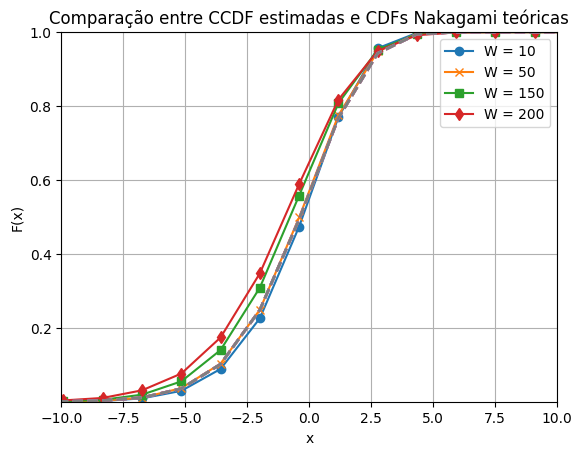

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from sklearn.metrics import mean_squared_error
from fGeraCanal import gera_canal
from fEstimaCanal import f_estima_canal

# Parâmetros para geração do canal sintético
sPar = {
    'd0': 5,                        # Distância de referência d0
    'P0': 0,                        # Potência medida na distância de referência d0 (em dBm)
    'nPoints': 50000,               # Número de amostras da rota de medição
    'totalLength': 100,              # Distância final da rota de medição
    'n': 4,                          # Expoente de perda de percurso
    'sigma': 6,                      # Desvio padrão do shadowing em dB
    'shadowingWindow': 200,          # Tamanho da janela de correlação do shadowing
    'm': 4,                          # Parâmetro de Nakagami
    'txPower': 0,                    # Potência de transmissão em dBm
    'nCDF': 40,                      # Número de pontos da CDF normalizada
    'dW': 100,                       # Janela de estimação do sombreamento
    'chFileName': 'Prx_sintetico',   # Nome do arquivo de canal
    'dMed': 100 / 50000              # Distância entre pontos de medição
}

# Gera o canal sintético
vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm = gera_canal(sPar)

# Exibe informações do canal sintético
print('Canal sintético:')
print(f'   Média do sombreamento: {np.mean(vtShadCorr)}')
print(f'   Std do sombreamento: {np.std(vtShadCorr)}')
print(f'   Janela de correlação do sombreamento: {sPar["shadowingWindow"]} amostras')
print(f'   Expoente de path loss: {sPar["n"]}')
print(f'   m de Nakagami: {sPar["m"]}')

# Várias janelas de filtragem para testar a estimação
vtW = [10, 50, 150, 200]
vtMSEShad = []
vtMSEFad = []
plt.figure()
chMarkers = ['o-', 'x-', 's-', 'd-', '>-', '^-', '-.']
for iw in range(len(vtW)):
    sPar['dW'] = vtW[iw]
    sOut = f_estima_canal(sPar)
    
    vtDistEst = sOut['vtDistEst']
    vtPathLossEst = sOut['vtPathLossEst']
    dNEst = sOut['dNEst']
    vtShadCorrEst = sOut['vtShadCorrEst']
    dStdShadEst = sOut['dStdShadEst']
    dStdMeanShadEst = sOut['dStdMeanShadEst']
    vtDesPequeEst = sOut['vtDesPequeEst']
    vtPrxEst = sOut['vtPrxEst']
    vtXCcdfEst = sOut['vtXCcdfEst']
    vtYCcdfEst = sOut['vtYCcdfEst']
    vtDistLogEst =np.log10(vtDistEst)
    vtDistLog = np.log10(vtDist)
    # MSE com Shadowing conhecido
    dMeiaJanela = round((sPar['dW'] - 1) / 2)
    len_min = min(len(vtShadCorr), len(vtShadCorrEst))
    mse_shad = mean_squared_error(vtShadCorr[dMeiaJanela+1:-dMeiaJanela], vtShadCorrEst)
    vtMSEShad.append(mse_shad)
    
        # MSE com Fading conhecido
    mse_fad = mean_squared_error(vtDesPequeEst, vtFading[dMeiaJanela+1:-dMeiaJanela])
    vtMSEFad.append(mse_fad)
    
    print(f'Estimação dos parâmetros de larga escala (W = {sPar["dW"]}):')
    print(f'   Expoente de perda de percurso estimado n = {sOut["dNEst"]}')
    print(f'   Desvio padrão do sombreamento estimado = {sOut["dStdShadEst"]}')
    print(f'   Média do sombreamento estimado = {sOut["dStdMeanShadEst"]}')
    print(f'   MSE Shadowing = {mse_shad}')
    print('----\n')
    plt.plot(sOut['vtXCcdfEst'], sOut['vtYCcdfEst'], chMarkers[iw % len(chMarkers)], label=f'W = {vtW[iw]}')
    

# Estudo na melhor janela de filtragem
print(f'Estudo na melhor janela de filtragem')
print(f'   Janelas utilizadas = {vtW}')
# Melhor janela com Shadowing conhecido
valBestShad = min(vtMSEShad)
posBestShad = vtMSEShad.index(valBestShad)
print(f'   Melhor MSE relativo aos valores reais do Shadowing (melhor janela):')
print(f'      Melhor janela W = {vtW[posBestShad]}: MSE Shadowing = {valBestShad}')
# Melhor janela com Fading conhecido
valBestFad = min(vtMSEFad)
posBestFad = vtMSEFad.index(valBestFad)
print(f'   Melhor MSE relativo aos valores reais do Fading:')
print(f'      Melhor janela W = {vtW[posBestFad]}: MSE Shadowing = {valBestFad}')
print('----------------------------------------------------------------------------------\n')
    
chLegendaW = [f'W = {w}' for w in vtW]
plt.legend(chLegendaW)

plt.xlabel('x')
plt.ylabel('F(x)')
plt.axis([-10, 10, 1e-5, 1])
plt.grid(True, which='both')
plt.title('Comparação entre CCDF estimadas e CDFs Nakagami teóricas')

# Plot das CDFs Nakagami teórica
vtm = sPar['m']
xCDF = 10 ** (sOut['vtXCcdfEst'] / 20)
tam_dist = len(xCDF)  # Tamanho da distribuição
for ik in range(vtm):
    im = vtm
    cdfnaka = gamma.cdf(im * xCDF ** 2, im)
    plt.plot(20 * np.log10(xCDF), cdfnaka, '--', linewidth=2)
        

# Cálculo do erro médio quadrático da CDF do Fading
print('MSE da CDF com várias janelas de filtragem com o conhecimento do Fading:')
vtm = [2,3,4,5]
mtMSEFad = np.zeros((len(vtm), len(vtW)))
for ik, m in enumerate(vtm):
    for il, w in enumerate(vtW):
        sPar['dW'] = w
        sOut = f_estima_canal(sPar)
        xCDF = 10 ** (sOut['vtXCcdfEst'] / 20)
        cdfnaka = gamma.cdf(m*xCDF**2, m)

        if np.any(np.isnan(sOut['vtYCcdfEst'])) or np.any(np.isnan(cdfnaka)):
            mse_fad_cdf = np.nan
        else:
            mse_fad_cdf = mean_squared_error(cdfnaka, sOut['vtYCcdfEst'])

        mtMSEFad[ik, il] = mse_fad_cdf
        print(f'  m = {m}: W = {w}: MSE Fading = {mse_fad_cdf}')
    print('----')

# Melhor m para cada W
vLinha = np.min(mtMSEFad, axis=0)          # menor MSE para cada W
posLinha = np.argmin(mtMSEFad, axis=0)     # melhor m (linha) para cada W

valCol = np.min(vLinha)                    # menor MSE global
posCol = np.argmin(vLinha)                 # W correspondente

bestLin = posLinha[posCol]                 # índice da melhor linha (m)
bestCol = posCol                           # índice da melhor coluna (W)
m_best = vtm[bestLin]
print(f'Melhor MSE relativo aos valores reais do fading:')
print(f'   W = {vtW[bestCol]} e m = {vtm[bestLin]}: MSE Fading = {valCol}')
print('----------------------------------------------------------------------------------\n')

plt.show()


Até esse momento nos concentramos em estimar os parâmetros do canal com o conhecimento a priori da série temporal do sombreamento e do desvnecimento de pequena escala. Contudo, para estimação de canal baseado em uma medição de campo (e não de um sinal sintético), esse conhecimento não é possível. Na verdade, conhecer as características estatísticas dessas séries temporais é a grande tarefa da estimação.  

Um método muito utilizado para estimação de parâmetros é o MLE (Maximum Likelihood Estimation). O MLE é um método de estimar os parâmetros ${\theta}$ de uma específica função distribuição de probabilidades $f(x_{i}|{\theta})$ de uma variável aleatória $X$ [[Fonte]](http://times.cs.uiuc.edu/course/410/note/mle.pdf). A estimação é baseada em amostras i.i.d. (independent and identically distributed) $x_{i}$ e na função  log-likelihood (máxima verossimilhança) definida como:

&nbsp; 
<center>
$\ell({\theta}) = \sum_{i=1}^{N} \log f (x_{i}| {\theta})$.
</center>

Então, o MLE escolhe os parâmetros $\hat{\theta}$ que maximiza a função de máxima verossimilhança, resultando nos parâmtros mais prováveis de gerar os dados observados [[Fonte]](https://www.jstage.jst.go.jp/article/iis/17/3/17_3_155/_pdf/-char/en).

Especificamente no MatLab, a função **fitdist** foi contruída para fazer o MLE [[Fonte]](https://www.mathworks.com/help/stats/fitdist.html#btu538h-pd).


**Passo 03:** Crie um script chamado **handson3_P3_3.py** com o código a seguir. Nesse código, vamos manter o mesmo código do **handson3_P3_2.py** e acrescentar:

1. Estimar via MLE os parâmetros das distribuição Nakagami, Rice, Rayleigh e Weibull para os dados do desvanecimento de pequena escala estimado para as várias janelas (usar comando **fitdist** do Matlab);
2. Além de constatar a possibilidade de parâmetros de para cada distribuição, inspecionaremos quais os parâmetros estimados para Nakagami, já que sabemos que esse é o tipo de canal gerado.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from fGeraCanal import gera_canal
from fEstimaCanal import f_estima_canal
from scipy.stats import nakagami, rice, rayleigh, weibull_min

# Parâmetros
sPar = {
    'd0': 5,
    'P0': 0,
    'nPoints': 50000,
    'totalLength': 100,
    'n': 4,
    'sigma': 6,
    'shadowingWindow': 200,
    'm': 4,
    'txPower': 0,
    'nCDF': 40,
    'dW': 100,
    'chFileName': 'Prx_sintetico'
}

sPar['dMed'] = sPar['totalLength'] / sPar['nPoints']

# Geração do canal sintético
vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm = gera_canal(sPar)

print("Canal sintético:")
print(f"   Média do sombreamento: {np.mean(vtShadCorr):.5f}")
print(f"   Std do sombreamento: {np.std(vtShadCorr):.5f}")
print(f"   Janela de correlação do sombreamento: {sPar['shadowingWindow']} amostras")
print(f"   Expoente de path loss: {sPar['n']}")
print(f"   m de Nakagami: {sPar['m']}")

# Estimação
vtW = [10, 50, 150, 200]
sOut = []
print("\nEstimação do Fading para várias janelas (estudo numérico sem conhecimento a priori do canal)")
print("Resultados com SciPy (equivalente ao fitdist do MATLAB)")

for iw, w in enumerate(vtW):
    sPar['dW'] = w
    out = f_estima_canal(sPar)
    sOut.append(out)
    env_norm = out['vtEnvNorm']
    print(f"Janela W = {w}")

    # Ajuste Nakagami
    m_naka, _, omega_naka = nakagami.fit(env_norm, floc=0)
    print(f"  Nakagami: m = {m_naka:.4f}, omega = {omega_naka:.5f}")

    # Ajuste Rice
    s_rice, _, sigma_rice = rice.fit(env_norm, floc=0)
    K_rice = s_rice**2 / (2*(sigma_rice** 2))
    print(f"  Rice: K = {K_rice:.4f}")

    # Ajuste Rayleigh
    _, sigma_rayleigh = rayleigh.fit(env_norm, floc=0)
    print(f"  Rayleigh: sigma = {sigma_rayleigh:.5f}")

    # Ajuste Weibull
    k_wei, _, lambda_wei = weibull_min.fit(env_norm, floc=0)
    print(f"  Weibull: k = {k_wei:.4f}, lambda = {lambda_wei:.5f}\n")

Canal sintético:
   Média do sombreamento: -0.28025
   Std do sombreamento: 5.96618
   Janela de correlação do sombreamento: 200 amostras
   Expoente de path loss: 4
   m de Nakagami: 4

Estimação do Fading para várias janelas (estudo numérico sem conhecimento a priori do canal)
Resultados com SciPy (equivalente ao fitdist do MATLAB)
Janela W = 10
  Nakagami: m = 4.5007, omega = 0.99984
  Rice: K = 145.4894
  Rayleigh: sigma = 0.70700
  Weibull: k = 4.5894, lambda = 1.06327

Janela W = 50
  Nakagami: m = 4.0422, omega = 0.99498
  Rice: K = 114.2147
  Rayleigh: sigma = 0.70356
  Weibull: k = 4.2647, lambda = 1.05862

Janela W = 150
  Nakagami: m = 3.6178, omega = 0.96706
  Rice: K = 93.2746
  Rayleigh: sigma = 0.68382
  Weibull: k = 3.9780, lambda = 1.02890

Janela W = 200
  Nakagami: m = 3.1799, omega = 0.95307
  Rice: K = 70.9731
  Rayleigh: sigma = 0.67392
  Weibull: k = 3.6915, lambda = 1.01327



**A execução do código resulta em:**
1. Mensagens de texto com informações sobre o canal sintético gerado;
2. Mensagens de texto com informações sobre os parâmetros das distribuições Nakagami, Rice, Rayleigh e Weibull que melhor se adequam aos dados do desvanecimento de pequena escala. Observe que a melhor janela é W = 50, que o $m$ d Nakagami é exatamente igual a 4.

**Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**


# Entrega 01: Códigos em Python

## Descrição da entrega

Tudo até agora foi feito com base em um sinal sintético gerado via simulação com o Matlab. Passe todo o código disponibilizado para Python e gere esse mesmo Jupyter notebook, mas com os códigos rodando em Python.

# Entrega 02: Frontend

## Descrição da entrega

Construa um frontend com as seguintes características:

1. Receber os parâmetros de geração do canal: o n do path loss; o sigma do shadowing; e o m de Nakagami;
2. Dar a opção de gerar os gráficos do canal gerado (colocar um botão para gerar os gráficos); 
3. Receber os parâmetros de extração das características do canal: o tamanho da janela de filtragem.
4. No painel de saída da estimação, informar: o expoente de perda de percurso estimado, o sigma do shadowing estimado e o m de Nakagami estimado; informar também o MSE do shadowing e do desvanecimento de pequena escala para o valor de janela de filtragem escolhido; e os gráficos comparando cada série estimada com seu par original.